---

## important parameters and diagnostics to be implemented

- Rossby radius of deformation
- Rhines lengthscale: $ L_\beta = \sqrt{\langle \zeta^2 \rangle} / \beta $ or $\langle (u^2+v^2) \rangle^{1/4} / \beta$
- Bottom drag time scale
- Forcing lengthscale 


- total energy, enstrophy, potential enstrophy
- kinetic energy spectra
- modal decomposition
- centroid wavenumber (function of time, surface, vs per mode)
- relative vorticity kurtosis : $ \langle \zeta^4 \rangle / \langle \zeta^2 \rangle^2 $

- movies of: relative vorticity (surface, modally projected)


things to vary: forcing strength, beta, central latitude (f=0?) 

## useful references

McWilliams, J. C. The emergence of isolated coherent vortices in turbulent flow. Journal of Fluid Mechanics 146 (1984), 21–43.

McWilliams, J. C. Statistical properties of decaying geostrophic turbulence. Journal of Fluid Mechanics 198 (1989), 199–230.

Smith, K. S., and Vallis, G. K. The Scales and Equilibration of Midocean Eddies: Freely Evolving Flow. J. Phys. Oceanogr. 31 (2001), 554–571.

---


STOCHASTIC FORCING of (balanced) TURBULENCE
===

In French: Forçage Stochastique de la Turbulence (FSTURB)

This configuration aims at generating slow/balanced turbulence with a stochatic forcing generated in horizontal wavenumber space.
Three dimension forcing fields are generated every $\Delta t$ (*fst_dt* in code) seconds and then linearly interpolated at every time step:

$$
\begin{align}
F(i,j,k,t) &= \frac{(n+1)\Delta t-t}{\Delta t} F_{n\Delta t}(i,j,k) 
+ \frac{t-n\Delta t}{\Delta t} F_{(n+1)\Delta t}(i,j,k) 
\\
\mathrm{for}\;\; n\Delta t&<t<(n+1)\Delta t
\end{align}
$$


The spatial structure of forcing fields are given by:

$$
\begin{align}
F_{n\Delta t}(i,j,k) = 
F_{T} \; 
W(i,j) \;
\times
iFFT
\Big \{
\sum_{m} N_{n\Delta t}(kx,ky,m) \psi(kx,ky,m) \phi_{m}(k)
\Big \}
\end{align}
$$

$ F_{T} $ is a constant corresponding to density forcing (will be declined into $ F_{u}, F_{v} $ later on ).

$ W(i,j) $ is a window that may tapper the forcing in physical space. 
Current implementation tappers in the y direction:

$$ W(i,j) = e^{-((yr(i,j)-y_{F})/(\Delta y_{F}))^{2}} $$

$N_{n\Delta t}(kx,ky,m)$ is a normal white noise.

$ \psi(kx,ky,m) $ is constant through the course of thenumerical simulation and modulates the forcing amplitude spectrally (horizontal, vertical modes).

$$ 
\psi (kx,ky,m)= \underbrace{a_{m}}_{mode} \underbrace{e^{-(kx^{2} + ky^{2} - kF^{2})/(\Delta kF^{2}) }}_{horizontal}
$$

$\phi_{n}$ are vertical normal modes


Implementation
===

- cppdefs.h : *FSTURB* is the cpp key that turns on the forcing
- ana_fsturb.F : new module which regroup initialisation and forcing computations
- main.F : forcing initialisation ( *call init_fsturb*)
- step.F : compute new forcing every $\Delta t$ time steps
- step3d_t.F : new forcing interpolated in time and z
 
Parameters names in code
===

- *fst_Nmode* : Number of modes
- *fst_dt* = 1.*86400
- *fst_a* : $a_{n}$ amplitude des différents modes
- *fst_xmid* : (not implemented)
- *fst_xwid* :
- *fst_ymid* : $ y_{F} $
- *fst_ywid* : $ \Delta y_{F} $
- *fst_FT* : $ F_{T} $
- *fst_kF* : $ kF $
- *fst_dkF* : $ \Delta kF $

Variables names
===

All variables related to the FSTURB forcing are declared in the fsturb modul, in the file 
*ana_fsturb.F*

- *fst_F(i,j,k,t)* : $ F_{n\Delta t}(i,j,k) $
- *fst_FT* : $ F_{T} $ défini en parameter dans le module
- *fst_W* : W(i,j)
- *fst_Noise* : $ N_{n\Delta t}(kx,ky,n) $ 
- *fst_a* : $a_{n}$ amplitude des différents modes
- *fst_psi* : $\psi(kx,ky,n)$
- *phir* : modes calculés dans vmodes


---

# balanced turbulence with internal waves configuration

The cpp key is ITBALT

The type of jet (1 to 4) is defined in `cppdefs.h`

Run time options are found in `croco.in`

## commands from start to finish:

Compilation:
```
./jobcomp
```

1 run at 4 km resolution:
```
python chain_datarmor.py fsturb_4km_0a100j 1 03:00:00 4 fs0 0
# and follow instructions
```

10 runs at 4 km resolution:
```
python chain_datarmor.py itbalt_4km_0a1000j 10 03:00:00 4 itb 0
# and follow instructions
```

Restart:
```
python chain_datarmor.py itbalt_4km_1000a1500j 5 03:00:00 4 itb 1
# and follow instructions
```

## outputs:

see [`iodef.xml`](iodef.xml)

### file_his_*.nc

Relevant temporal variable: `time_counter`

Variables are 2D or 3D:

- `v_a` : temporal averaged of variable $v$

- `v_t_cos` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_sin` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_dirac` : instantaneous value of $v$ at the center of the interval

The relevant time interval for this output has size `freq_op` (2d typically) and is outputed every `output_freq` (25d typically).

![his](../JETN/croco_jetn_time.001.png)


### file_ave_*.nc

Relevant temporal variable: `time_counter`

Variables are 2D and averaged over a temporal window of size `output_freq` (2d typically).

- `v` : temporal averaged of variable $v$

- `v_t_cos` : temporal averaged of $v\times\cos(\omega t)$

- `v_t_sin` : temporal averaged of $v\times\cos(\omega t)$

![ave](../JETN/croco_jetn_time.002.png)

### file_surf_*.nc

Relevant temporal variable: `time_instant`

Variables are 2D (surface) and instantaneous every `output_freq` (10 min typically).

### file_inst_*.nc, file_sta1_*.nc, ...

Relevant temporal variable: `time_instant`

Variables are 1D and instantaneous every `output_freq` (30min typically).

### file_swath_*.nc

Not that useful for now.


### nicer treatment of time coordinate

Work is ongoing around xarray in order to implement useful features for this
such as selection alon non-dim coordinates [issue](https://github.com/pydata/xarray/issues/1603)


---

# vertical modes


$\phi$ is the vertical structure function of the (u,v,p) and satisfies:

$$
\begin{align}
\frac{d}{dz} \Big (  \frac{1}{N^2} \frac{d}{dz} \phi  \Big )
+ \frac{1}{c^2} \phi = 0, \\
g \frac{d}{dz} \phi + N^2 \phi = 0 
\;\; \mathrm{at} \;\; z=0 \\
\frac{d}{dz} \phi = 0 
\;\; \mathrm{at} \;\; z=-h
\end{align}
$$

where c is the eigenvalue to be determined.
Variables will be projected according to:

$$
\begin{align}
\big [ u, v, p \big ] = 
\sum_m \big [ \hat{u}_m , \hat{v}_m , \hat{p}_m \big ]
\times \phi_m \\
\big [ \rho, w \big ] = 
\sum_m \big [ \hat{\rho}_m, \frac{1}{N^2(z)}\hat{w}_m  \big ]
\times  \frac{d}{dz}\phi_m
\end{align}
$$

Normalization is such that: 

$$
\begin{align}
\frac{1}{h}\int \phi_m^2 dz &= 1, \\
\frac{1}{h}\int \frac{1}{N^2} \Big ( \frac{d}{dz} \phi_n \Big )^2 dz &= \frac{1}{c_n^2} - \frac{\phi_n^2(0)}{gh}.
\end{align}
$$



References: Gill p160, Kloosterziel 1995 
($\hat{p}$ of Gill is $\phi$ of kloorsterziel)



---

# play with 2D FFT

In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
Nx = 256
Ny = Nx*3

kx, ky = (np.fft.fftfreq(n) for n in [Nx, Ny])
kx2 = kx[:,None]+0*ky[None,:]
ky2 = 0*kx[:,None]+ky[None,:]
kk = np.sqrt(kx2**2+ky2**2)

kF = 1/20
dkF = kF/2

psi = (np.exp(-(kk-kF)**2/dkF**2)).astype(np.complex)
psi = psi/np.sqrt(np.sum(abs(psi[:])**2))*Nx*Ny # normalize
#rand = np.random.randn(Ny, Ny)
rand = np.random.uniform(low=-1., high=1., size=(Ny, Ny))
r = np.random.randn(Nx, Ny).astype(np.complex) \
        + 1j*np.random.randn(Nx, Ny).astype(np.complex)
print(np.std(r[:]))
# note r does not respect hermitian symmetry
psi *= r

1.412226591643158


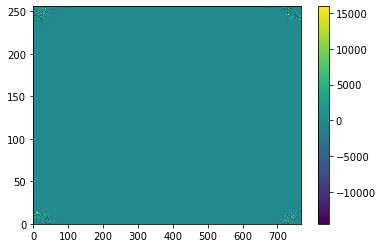

In [3]:
plt.pcolor(np.real(psi))
plt.colorbar()

In [4]:
ipsi = np.fft.ifft2(psi)
ipsi

array([[-1.63896959+0.59217628j, -1.55713116+0.67952156j,
        -1.32996783+0.72198812j, ..., -1.05743138-0.01247168j,
        -1.36497121+0.24622869j, -1.56973457+0.44896585j],
       [-1.5755725 +0.53614844j, -1.53878459+0.65235921j,
        -1.36161092+0.72478775j, ..., -0.94923476-0.12274744j,
        -1.25168769+0.14625636j, -1.4727293 +0.36782626j],
       [-1.46493487+0.5454101j , -1.46893368+0.67656619j,
        -1.33845045+0.76138726j, ..., -0.79982056-0.14698209j,
        -1.09750366+0.12861192j, -1.33245867+0.3622239j ],
       ...,
       [-1.36759408+0.89636825j, -1.16985936+0.8616008j ,
        -0.82759578+0.7668794j , ..., -0.93166074+0.54112978j,
        -1.24234319+0.73847581j, -1.39349853+0.85731819j],
       [-1.54027259+0.80247185j, -1.37483114+0.80922516j,
        -1.06109199+0.76158312j, ..., -1.05313547+0.35287806j,
        -1.36712993+0.57688775j, -1.53711881+0.72714797j],
       [-1.63136179+0.69075804j, -1.50535398+0.73991058j,
        -1.23104974+0.74022411

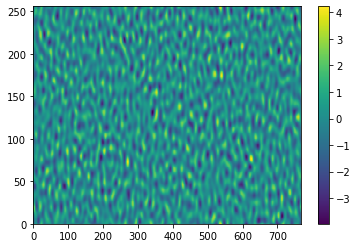

In [5]:
plt.pcolor(np.real(ipsi))
plt.colorbar()

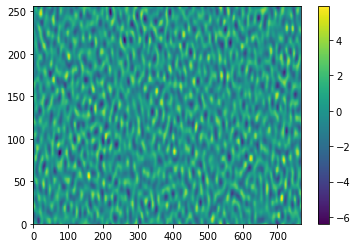

In [6]:
ipsi = np.fft.irfftn(psi[:,:int(Ny/2)+1])
plt.pcolor(ipsi)
plt.colorbar()

In [7]:
np.std(ipsi[:])

1.413071769592352